# Attention & Transformers

In this lecture we will study the currently most popular neural network architecture, i.e. transformers, and the underlying mechanism it uses for passing information between units, i.e. attention.

We will switch from computer vision tasks to natural language processing (NLP), which is naturally suited for sequence models like the transformer.

- Acknowledgment: Illustrations are taken from [Jay Alammar](https://jalammar.github.io/illustrated-transformer/) <- highly recommended read.
- Original paper: [Attention is all you need](https://arxiv.org/abs/1706.03762)

## NLP: Sequence generation

We will work on the tiny shakespeare dataset and train a model

In [1]:
import math
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

cuda


In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2024-12-14 21:34:49--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-12-14 21:34:49 (33.6 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
with open("input.txt", "r", encoding="utf-8") as f:
  text = f.read()
print("length of dataset in characters: ", len(text))


length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# check the unique characters in the dataset
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

# takes a string, output a list of integers and vice versa
encode = lambda s: [ stoi[c] for c in s]
decode = lambda l: "".join([ itos[i] for i in l])

print(encode("hi there"))
print(decode(encode("hi there")))

[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
data = torch.tensor(encode(text), dtype = torch.long)

In [8]:
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [9]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print((len(train_data), len(val_data)))

(1003854, 111540)


In [10]:
# time dimension (chunks of data)
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]
y = train_data[1: block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is: {context} the target is: {target} ")

when input is: tensor([18]) the target is: 47 
when input is: tensor([18, 47]) the target is: 56 
when input is: tensor([18, 47, 56]) the target is: 57 
when input is: tensor([18, 47, 56, 57]) the target is: 58 
when input is: tensor([18, 47, 56, 57, 58]) the target is: 1 
when input is: tensor([18, 47, 56, 57, 58,  1]) the target is: 15 
when input is: tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47 
when input is: tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58 


In [12]:
# Create a dataloader that will sample context and target pairs

from torch.utils.data import Dataset, DataLoader

class CustomTextDataset(Dataset):
    def __init__(self, data, blocksize):
        self.data = data
        self.blocksize = blocksize

    def __len__(self):
        return (len(self.data) - 1) // self.blocksize

    def __getitem__(self, idx):
        assert idx + self.blocksize + 1 < len(self.data), "idx too large"
        context = self.data[idx*self.blocksize:(idx+1)*self.blocksize]
        target = self.data[idx*self.blocksize+1:(idx+1)*self.blocksize+1]
        return context, target

In [13]:
# iterate through dataloader

dataloader = DataLoader(CustomTextDataset(train_data, 8), batch_size=4)

print(len(dataloader))
for i, (context, target) in enumerate(dataloader):
    pass
    #print(f"Context: \n{context} \nTarget:\n{target}")
    #if i >= 4:
    #    break

31371


### Data Loader explanation

1. Chunking the Data:
   - Why? Transformers, especially large ones like GPT, can be computationally expensive. Instead of feeding the entire text sequence into the Transformer, chunks of data are used.
   - Block Size: This is a term used for the maximum length of these chunks. It's also sometimes referred to as 'context length'. A block size of 8 means each chunk will be 8 characters long.

2. Multiple Examples in a Single Chunk:
   - Overlap Training: For a block size of 8, there are actually 8 training examples. For example, for a sequence "12345678", the model learns that after "1" comes "2", after "12" comes "3", and so on.
   - Why Plus One?: When taking a chunk, it's actually of size block_size + 1 (9 in the example). This is because, for training, one character is used as input and the next character as the expected output.

3. Training on Diverse Contexts:
   - Training isn't just done on sequences of length 8 (or block size). It's done on sequences of length 1 to 8. This makes the Transformer accustomed to making predictions on contexts ranging from a single character up to the full block size.
   - Advantage: During inference, this flexibility means we can generate sequences starting from just one character. After reaching the block size, we would need to truncate or remove some of the context to continue generating.

# Text Generation Approach

In what follows, we will develop an autoregressive architecture (the transformer decoder) that will generate one character at a time conditioned on the previsouly seen/generated characters.

Formally, we will execute

>For i=1,...:
>
> > $x_i \sim p(\cdot | x_1,\ldots,x_{i-1})$

where $x_i$ is the $i$-th character in our sequence.

# Transformer Architecture

We want to train a model that, given a chunk of text, predicts a continuation, one token at a time. To this end, we will investigate the transformer architecture.

#### Token Embedding
The input data are a sequence of characters (= tokens).
For each character, we look up its corresponding embedding, i.e. a learnable feature vector (= token embedding).
This transformation character $\rightarrow$ embedding is done initially and the feature vector is fed into the transformer.

<img src="embeddings.png" alt="Embedding" width="600"/>

#### Encoder/Decoder

A transformer is composed of two main parts: 
- encoder: Processes input and compiles information into features
- decoder: Produces output one by one (autoregressively), conditioned on the encoder features and previous features computed by the decoder. This is the part that we will finally use.

We will study the encoder first, since it is simpler but already contains most of the components in the decoder.

<video src="seq2seq_3.mp4" width="320" height="240" controls></video>

The encoder and decoder is composed of a number of blocks, each of which have the same structure but typically their own set of weights.

<img src="The_transformer_encoder_decoder_stack.png" alt="Transformer Encoder/Decoder" width="600"/>

Each encoder block consists of two parts:
- Attention: Exchange information between different tokens (= individual feature vectors), used for mixing information between tokens.
- MLP: Independently apply a transformation for each token, no information sharing is happening

The sequence of feature vectors, which we call **tokens** is fed into the an encoder layer as follows:

<img src="encoder_with_tensors_2.png" alt="Transformer Encoder" width="600"/>

## Self-Attention

Self-Attention, one form of attention, is used to mix information between different tokens.

#### First Step: Queries, Keys, Values

We create three vectors from each token:
- Query: They can be thought of as the "questions" we ask to the keys. We use queries to search for specific information in our input data.
- Key: They can be thought of as the "labels" for the input data in the context of attention. When we calculate attention scores, we compare the queries to these keys.
- Value: Once we have our attention scores, we use them to create a weighted combination of the values. Think of values as the actual content associated with each key.

All three vectors are obtained by a linear map form the token's feature vector.
Typically, their dimension is smaller than the feature dimension.

<img src="transformer_self_attention_vectors.png" alt="Queries/Keys/Values" width="600"/>

##### QKV Interpretation

QKV functions similarly to retrieval systems:

- query = text in the search bar
- matched against a set of keys = video title, description, etc.
- associated with values = candidate videos in their database,

The retrieval process presents the best matched videos (= values).

#### Second Step: Computing Scores for Attention

Queries and keys are multiplied together to get scores for attention. A high score means that a token focuses on information contained in the feature vector of another token.

<img src="transformer_self_attention_score.png" alt="Scores" width="600"/>

#### Third Step: Normalize Scores

We pass the scores through a softmax layer to get positive numbers that sum up to one. The resulting attention weights will be used to mix information from other tokens in our sequence.
For numerical stability we divide the scores by the dimension of query and key vectors $d_k$.

<img src="self-attention_softmax.png" alt="Softmax on Scores" width="600"/>

#### Fourth Step: Average Values

We multiply each value vector by the attention weights and sum them up.
In this way, information from multiple tokens is fused into a single feature vector.

<img src="self-attention-output.png" alt="Sum Values" width="600"/>

#### Matrix Calculus

It would be inefficient to iterate over multiple tokens and calculate queries/keys/values one by one. We instead use a more compact matrix representation.

<img src="self-attention-matrix-calculation.png" alt="QKV Matrix Calculus" width="600"/>

We can compute scores and sum up values similarly using matrix products.

<img src="self-attention-matrix-calculation-2.png" alt="Scores/Summation Matrix Calculus" width="600"/>



In [14]:
class Attention(nn.Module):
    def __init__(self, dim, head_size):
        super(Attention, self).__init__()
        self.K = nn.Linear(dim, head_size, bias=False)
        self.Q = nn.Linear(dim, head_size, bias=False)
        self.V = nn.Linear(dim, head_size, bias=False)
    
    def forward(self, x):
        key = self.K @ x
        query = self.K @ x
        value = self.K @ x
        scores = key @ query.transpose(-2, -1) # (B,T,C) @ (B,C,T) -> (B,T,T)
        att_wei = F.softmax(scores / np.sqrt(x.shape[-1]), dim=-1)
        out = att_wei @ value
        return out
        

### Multi-Head Attention

A single attention block is in practice not enough. We may want to aggregate informations in multiple and different ways. To this end, we execute multiple self-attention heads in parallel.

<img src="transformer_attention_heads_qkv.png" alt="Multi-Head Attention" width="600"/>

This results in multiple attention results.

<img src="transformer_attention_heads_z.png" alt="Multi-Head Attention Output" width="600"/>

Finally, we merge all attention outputs by concatenating them and multiplying with a matrix $W^O$.

<img src="transformer_attention_heads_z.png" alt="Multi-Head Attention Output Fusion" width="600"/>

All in all, self-attention can be summarized as

<img src="transformer_multi-headed_self-attention-recap.png" alt="Multi-Head Self-Attention Overall" width="600"/>

In [15]:
class MHA(nn.Module):
    def __init__(self, C, head_size, nr_heads):
        super(MHA, self).__init__()
        self.heads = [Attention(C, head_size) for _ in range(nr_heads)]
        self.Z = nn.Linear(nr_heads * head_size, C)
    
    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.Z(out)

### Positional Encoding

The transformer is equivariant regarding the order of tokens. If we permute the token order, the output feature vectors will be permuted in the same way.
Note that this is not what should happen in most circumstances, e.g. for text data, where the order in which words occur is important.

To add positional information, we will add positional encodings to each token. 
For each position in the sequence, we will have one vector with a spacific pattern from which the transformer will be able to infer the token position.

<img src="transformer_positional_encoding_example.png" alt="Positional Encoding" width="600"/>

The classical choice from the transformer paper has been to use sine and cosine functions with different frequencies to encode positions.

$$
\text{PE}{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d{\text{model}}}}\right)
$$

$$
\text{PE}{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d{\text{model}}}}\right)
$$

Here
- $pos$ is the position in the sequence.
- $i$ is the dimension.
- $d_{\text{model}}$ is the dimensionality of the model.

<img src="transformer_positional_encoding_large_example.png" alt="Positional Encoding" width="600"/>

Nowadays, learned positional embeddings have become more popular.
We will stick to sinusoidal encodings in this lecture, though.


In [16]:
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

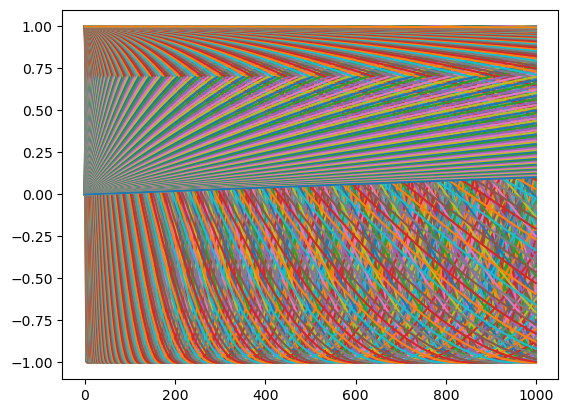

In [17]:
pe = positionalencoding1d(512, 1000)
plt.plot(pe.numpy())

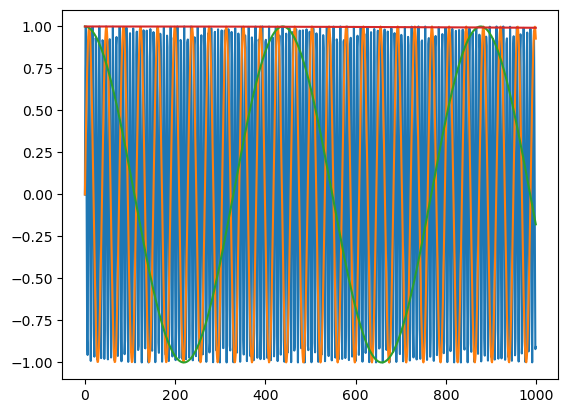

In [18]:
x = range(1000)
plt.plot(x, pe[:, 10].numpy(), label="dim 10")
plt.plot(x, pe[:, 100].numpy(), label="dim 100")
plt.plot(x, pe[:, 237].numpy(), label="dim 237")
plt.plot(x, pe[:, 501].numpy(), label="dim 501")

## Transformer Encoder: Full Architecture

Taking everything together, one transformer encoder layer is as follows:

<img src="transformer_resideual_layer_norm_2.png" alt="Positional Encoding" width="600"/>

We add residual connections and layer normalization to improve training.

In [19]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim, nr_heads, head_size, ff_size):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MHA(dim, head_size, nr_heads)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_size),
            nn.GeLU(),
            nn.Linear(ff_size, dim)
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + self.mha(x)
        x = self.ln1(x)
        x = x + self.ff(x)
        x = self.ln2(x)
        return x

In the feedforward submodule we have two layers, the first doing a fan-out (often ff_size = 4*dim), a nonlinearity followed by a fan-in linear layer.o

When we stack multiple encoder layers together we get the full transformer encoder.

In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, nr_heads, head_size, ff_size, depth, max_len):
        self.layers = [TransformerEncoderLayer(dim, nr_heads, head_size, ff_size) for _ in range(depth)]
        self.pe = positionalencoding1d(dim, 5*max_len)
    
    def forward(self, x):
        x = x + self.pe[:x.shape[1]]
        for layer in self.layers:
            x = layer(x)
        return x

## Transformer Decoder

The transformer encoder processes a sequence of tokens. In particular,
$\#$ input tokens $=$ $\#$ out put tokens.

In order to generate new tokens, we will use a decoder. 
The decoder autoregressively generates one token after the other.
While doing so, the current token is conditioned on 
- previously encoded features from the encoder via cross-attention.

<img src="transformer_decoding_1.gif" alt="Positional Encoding" width="600"/>

- previously generated intermediate feature vectors via causal self-attention,

<img src="transformer_decoding_2.gif" alt="Positional Encoding" width="600"/>

An additional architectural difference is that we have to generate a new token. This is done via an output head that produces scores for each word in the output vocabulary.

<img src="transformer_resideual_layer_norm_3.png" alt="Positional Encoding" width="600"/>



#### Cross-Attention = Encoder/Decoder Attention

In cross attention there are two sources of tokens:
- Key and Value: From tokens in the encoder
- Query: From tokens in the decoder

In [21]:
class Attention(nn.Module):
    def __init__(self, dim, head_size):
        super(Attention, self).__init__()
        self.K = nn.Linear(dim, head_size, bias=False)
        self.Q = nn.Linear(dim, head_size, bias=False)
        self.V = nn.Linear(dim, head_size, bias=False)
        
    def forward(self, decoder, encoder=None):
        if encoder is None:
            encoder = decoder
        key = self.K @ encoder
        query = self.Q @ decoder
        value = self.V @ encoder
        scores = key @ query.transpose(-2, -1)
        att_wei = F.softmax(scores, dim=-1)
        out = att_wei @ value
        return out

## Causal Self-Attention

When we generate text, a token at position $k$ cannot attent to tokens at positions $> k$, since they have not been generated yet.
In order to respect the arrow of time, we add a mask that suppresses attending to future tokens.

In [22]:
class Attention(nn.Module):
    def __init__(self, dim, head_size):
        super(Attention, self).__init__()
        self.K = nn.Linear(dim, head_size, bias=False)
        self.Q = nn.Linear(dim, head_size, bias=False)
        self.V = nn.Linear(dim, head_size, bias=False)
    
    def forward(self, decoder, encoder=None, causal=False):
        if encoder is None:
            encoder = decoder
        key = self.K(encoder)
        query = self.Q(decoder)
        value = self.V(encoder)
        scores = key @ query.transpose(-2, -1) # (B,T,C) @ (B,C,T) -> (B,T,T)

        if causal:
            T = scores.shape[1]
            mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(scores.device)
            scores = scores.masked_fill(mask, float('-inf'))

        att_wei = F.softmax(scores, dim=-1)
        out = att_wei @ value
        return out

In [23]:
# Rewrite MHA to support cross and causal attention
class MHA(nn.Module):
    def __init__(self, C, head_size, nr_heads):
        super(MHA, self).__init__()
        self.heads = nn.ModuleList([Attention(C, head_size) for _ in range(nr_heads)])
        self.Z = nn.Linear(nr_heads * head_size, C)
    
    def forward(self, decoder, encoder=None, causal=False):
        out = torch.cat([head(decoder, encoder, causal) for head in self.heads], dim=-1)
        return self.Z(out)

We will use a pure decoder only architecture, following LLM architectural choices. 
Our transformer decoder layer therefore will omit the cross attention.

In [24]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, dim, nr_heads, head_size, ff_size):
        super(TransformerDecoderLayer, self).__init__()
        self.causal = MHA(dim, head_size, nr_heads)
        self.ln1 = nn.LayerNorm(dim)
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_size),
            nn.GELU(),
            nn.Linear(ff_size, dim)
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x):
        x = x + self.causal(x, causal=True)
        x = self.ln1(x)
        x = x + self.ff(x)
        x = self.ln2(x)
        return x

In [25]:
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nr_heads, head_size, ff_size, depth, max_len):
        super(TransformerDecoder, self).__init__()
        self.em = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, nr_heads, head_size, ff_size) for _ in range(depth)])
        pe = positionalencoding1d(d_model, 5*max_len)
        self.register_buffer('pe', pe)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.em(x)
        x = x + self.pe[:x.shape[1]]
        for layer in self.layers:
            x = layer(x)
        x = self.head(x)
        return x

The autoregressive generation loop becomes a sequential loop that adds one token at a time.

In [37]:
def generate(decoder, start_char, max_new_tokens, block_size=32):
    idx = torch.tensor(encode(start_char)).unsqueeze(0).to(device)
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:,-block_size:]
        # get the predictions
        logits = decoder(idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B,C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B,C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)
    text = [decode(idx[i].tolist()) for i in range(idx.shape[0])]
    return text

In [27]:
# generate some text
decoder = TransformerDecoder(512, 8, 64, 2048, 6, 8).to(device)
start_char = 'P'
generated_text = generate(decoder, start_char, max_new_tokens=50, block_size=32)
print(generated_text)

SrKjLsibnf::wRl!b:$-?O
lncUQVfXH.-bsa&Y&ZYfSJvsqbeDjQufNWH!GjUmm&&JydclnwAe--X j&rh.,xCCxaMFCKrXwMqvwlZ&oSTK


We get some completely random text out from the decoder.
Now we want to train the transformer, so that it decodes text similar to the training corpus.
For this, we will train the transformer to predict the next token it is presented.

Importantly, the parallel nature of the transformer allows us to train next token prediction for all tokens in the sequence simultaneously, making training fast.

- Training = parallel token prediction for all tokens in the sequence -> utilize GPU, reuse nodes in computational graph
- Inference = sequential decoding, one token at a time -> sometimes runs equally fast on CPU (when only decoding one sequence)

In [34]:
blocksize = 64
batchsize = 32

decoder = TransformerDecoder(512, 8, 64, 2048, 6, blocksize).to(device)
optimizer = torch.optim.AdamW(decoder.parameters(), lr=0.0001, weight_decay=0.0001)
dataloader = DataLoader(CustomTextDataset(train_data, blocksize), batch_size=batchsize, shuffle=True)

nr_epochs = 15
losses = []

for epoch in range(nr_epochs):

    decoder.train()
    total_loss = 0.0

    for context, target in dataloader:
        context = context.to(device)
        target = target.to(device)

        pred = decoder(context)

        loss = F.cross_entropy(pred.reshape(-1,pred.shape[-1]), target.reshape(-1))
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses.append(total_loss/len(dataloader)/blocksize/batchsize)
    print(f"Epoch {epoch} Training loss: {total_loss}")

Epoch 0 Training loss: 1042.8915895223618
Epoch 1 Training loss: 830.0654017925262
Epoch 2 Training loss: 766.0124909877777
Epoch 3 Training loss: 729.7341719865799
Epoch 4 Training loss: 703.3559365272522
Epoch 5 Training loss: 683.2730133533478
Epoch 6 Training loss: 664.5532115697861
Epoch 7 Training loss: 647.5934636592865
Epoch 8 Training loss: 631.4927476644516
Epoch 9 Training loss: 616.2341924905777
Epoch 10 Training loss: 599.3644684553146
Epoch 11 Training loss: 582.4401406049728
Epoch 12 Training loss: 564.8916589021683
Epoch 13 Training loss: 546.1076644659042
Epoch 14 Training loss: 526.6412593722343


In [ ]:
# generate some text
idx = torch.randint(0, vocab_size, (1, 8)).to(device)
idx_generated = generate(decoder, idx, 100, 8)
print(idx_generated)
decode(idx_generated[0].tolist())

tensor([[20, 38,  7, 28,  0, 19, 34, 25, 28, 33, 24, 21, 27, 10,  0, 35, 43, 50,
         50,  6,  1, 51, 63,  1, 41, 53, 59, 57, 47, 52,  5, 57,  1, 57, 41, 53,
         58, 41, 46, 43, 42,  1, 61, 47, 58, 46,  1, 45, 56, 47, 43, 44,  1, 57,
         58, 47, 56, 56,  1, 61, 46, 47, 41, 46,  1, 57, 46, 43,  1, 52, 43,  5,
         43, 56,  1, 46, 39, 57,  1, 63, 53, 59, 56,  0, 47, 57,  1, 40, 59, 57,
         47, 52, 43, 57, 57, 10,  1, 46, 43,  1, 57, 54, 43, 43, 42, 57,  1, 57]],
       device='cuda:0')


In [38]:
decode(idx_generated[0].tolist())

"HZ-P\nGVMPULIO:\nWell, my cousin's scotched with grief stirr which she ne'er has your\nis business: he speeds s"